# L4: Queueing Theory


In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [3]:
from scipy.linalg import expm

In [4]:
def get_filename(filename: str, lecture_id: int = 1, file_extension: str = '.png') -> str:
    return f"L{lecture_id}_{filename}{file_extension}"

outdir = '../figures/'
lecture_id = 4

In [5]:
def zero_runs(a: np.ndarray, is_zero: bool = True):
    '''
    Find intervals where a==0 (or different)
    '''
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    if is_zero == True:
        iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    else:
        iszero = np.concatenate(([0], (np.equal(a, 0)==False).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [6]:
'''
------------------------------------------
            SETTINGS
------------------------------------------
'''
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = 'PT Sans'
# plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 12

fs = 20
dpi = 100

## 1. Unfinished work $v(t)$
Let's explore how this function looks like. 
For this we first need to specify:  
    - Arrival times $\tau_n$  
    - Service times $x_n$

#### 1.1 Arrival times

- i.i.d. exponentially distributed

In [149]:
seed = 10
prng = np.random.RandomState(seed)


In [206]:
n = 1000 # number of packets
lambda_tau = 1. # E[tau] = 1/lambda_tau
taus = prng.exponential(scale=1/lambda_tau, size=n)

#### 1.2 Service time
- Deterministic


In [207]:
x = 0.8
xs = x * np.ones(n)

Let's check the traffic intensity:
- $\rho = \frac{E[x]}{E[\tau]}$

Expected service time over expected arrival time, the larger this number the busier the system gets. 

In [208]:
rho = np.mean(xs) / np.mean(taus)
print(f"rho={rho:.2f}")

rho=0.79


#### 1.3 Simulate $v(t)$
We can now build functions to simulate $v(t)$ using:

$v(t_{n}) = T_{n} = w_{n}+x_{n}$

First we need to calculate $t_n$ from the interarrival $\tau_n$

In [209]:
taus[:5]

array([0.30571457, 0.13049136, 0.61382639, 3.68140742, 1.14123082])

In [210]:
ts = np.cumsum(taus)
ts[:5]

array([0.30571457, 0.43620593, 1.05003232, 4.73143973, 5.87267055])

In [211]:
def simulate_queueing_system(taus: np.ndarray, xs: np.ndarray):
    n = taus.shape[0]
    assert xs.shape[0] == n

    w = np.zeros(n) # waiting time
    T = np.zeros(n) # service time
    v = np.zeros(n) # workload

    '''
    Initial time step
    Computed at time of initial arrival
    '''
    w[0] = 0 # waiting times
    T[0] = xs[0] + w[0]
    v[0] = T[0]
    
    '''
    t > 0
    '''
    for j, tau in enumerate(taus[1:]):
        i = j+1
        # t_n = np.cumsum(taus[i])
        w[i] = max(w[i-1] + xs[i-1] - tau,0)
        T[i] = w[i] + xs[i]
        v[i] = T[i]

    return w,T,v


In [212]:
w,T,v = simulate_queueing_system(taus,xs)

So far this simulates **at** discrete time steps $t_n$.  
But we can also fill the gaps **between** two successive $(t_n,t_{n+1})$, using:

$v(t) = \max \{T_{n} - (t -t_{n}), 0\} $

In [213]:
def get_intermediate_v(v,T,t, s = 100)-> np.ndarray:
    '''
    Get a continous-like representation of v (not just at discrete arrival/departures)
    '''
    n = v.shape[0]
    Xaxis = [] #  x-values to sample in the x-axis
    
    xs = np.linspace(0,ts[0],s) # first time steps
    Xaxis.extend(list(xs))
    new_v = [0 for x in xs]
    new_v[-1] = v[0]
    for i in range(1,n):
        xs = np.linspace(ts[i-1],ts[i],s) # first time steps
        for t in xs:
            v_t = max(T[i-1] - (t - ts[i-1]),0)
            new_v.append(v_t)
        # new_v[-1] = v[i]
        Xaxis.extend(xs)
    return new_v, Xaxis
   

And we can also track $N_S(t)$, the number of packets under service at time $t$.  
For this, you need the arrival times $t_n$ and departure times $r_n$ and then update $N_S(t)$:
- Each time a packet arrives in the queue: `N_S(t) += 1`
- Each time a packet departs the system: `N_S(t) -= 1`

In [284]:
     
def get_N_S(T,ts, s = 100) ->(list,list):
    '''
    Get a continous-like representation of N_S (not just at discrete arrival/departures)
    '''
    n = T.shape[0]
    assert n == ts.shape[0], f"{n},{ts.shape[0]}"
    
    rs = ts + T # departure times
    Xaxis = [] #  x-values to sample in the x-axis
    
    xs = np.linspace(0,ts[0],s) # first time steps
    Xaxis.extend(list(xs))
    N_S = [0 for x in xs]
    N_S[-1] = 1 # first time interval recieves one packet at time ts[0] (the first)
    queue = [0]
    for i in range(1,n):
        xs = np.linspace(ts[i-1],ts[i],s) # first time steps
        for t in xs:
            departed = []
            N_S_t = N_S[-1]
            for j in queue: # run over all packets in the queue and check if they depart
                if t > rs[j]: # packet i-th departs
                    N_S_t = max(N_S_t-1,0)
                    departed.append(j)

            N_S.append(N_S_t)
            queue = [j for j in queue if j not in departed]
        N_S[-1] += 1
        queue.append(i)
        Xaxis.extend(xs)
    return N_S, Xaxis

In [215]:
s = 100
new_v, Xaxis = get_intermediate_v(v,T,ts,s=s)
N_S, XaxisS = get_N_S(T,ts,s)

assert len(N_S) == len(XaxisS)

In [216]:
if n < 20:
    filename = 'queue_basic_stats'
    outfile = get_filename(filename,lecture_id=lecture_id)
else:
    outfile = None

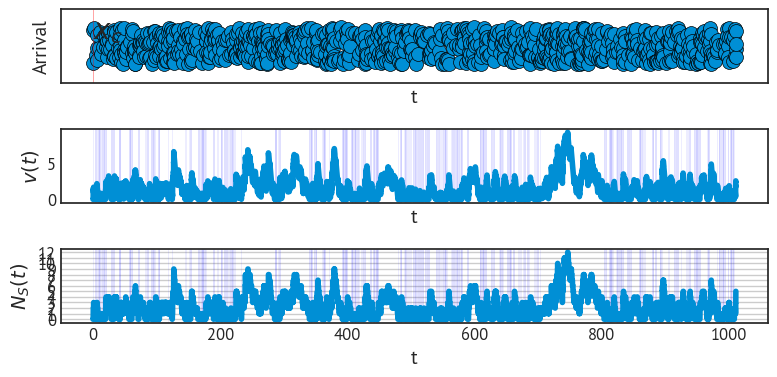

In [217]:

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,4))

ax[0].scatter(ts, np.ones(n) * prng.uniform(-1,1, size=n) * 0.5, s = 100, edgecolors='black')
ax[0].set_ylabel('Arrival')
ax[0].set_xlabel('t')
ax[0].set(yticklabels=[])
ax[0].set_ylim(-1,1)
# plt.yticks(np.arange(1,2))

ax[1].plot(Xaxis,new_v)
ax[1].set_ylabel(r'$v(t)$')
ax[1].set_xlabel('t')

ax[2].plot(XaxisS,N_S)
ax[2].set_ylabel(r'$N_S(t)$')
ax[2].set_xlabel('t')
ax[2].set_yticks(np.arange(max(N_S)+1))
ax[2].grid(axis='y')

'''
Highlight idle times
'''
idle_times = zero_runs(new_v)
for i,(a,b) in enumerate(idle_times):
    ax[1].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')
    ax[2].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')

'''
Highlight mean service time
'''
ax[0].fill_betweenx(np.ones(n),np.zeros(n),np.mean(xs) * np.ones(n))
ax[0].axvspan(0, np.mean(xs), alpha=0.5, color='red')
ax[0].plot([0,np.mean(xs)],[0,0],lw=5,color='r')
ax[0].text(np.mean(xs) * 0.5 * 0.9,0.2,r'$x_c$', fontsize=20)
plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

- Blue shades show idle times
- Red area shows the expected service time $x_c = E[x]$

#### 1.4 Investigate waiting times 

In [218]:
outfile = None

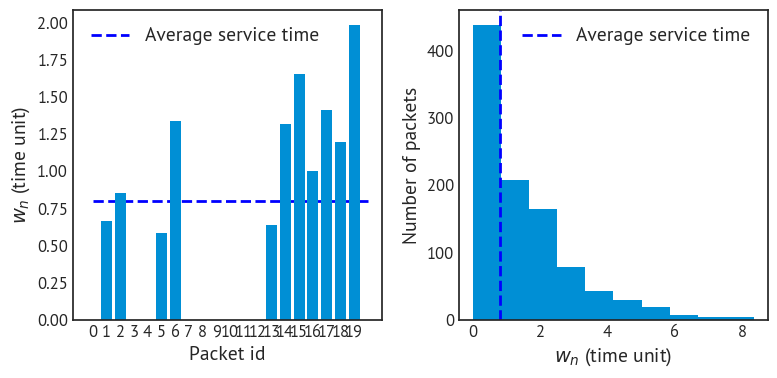

In [219]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

nmax = min(n,20)
ax[0].bar(np.arange(n)[:nmax], w[:nmax])
ax[0].set_xlabel('Packet id')
ax[0].set_ylabel(r'$w_n$ (time unit)')
ax[0].set_xticks(np.arange(n)[:nmax],labels=np.arange(n)[:nmax])
x_axis = np.linspace(0,nmax,100)
avg_xs = np.mean(xs)
ax[0].plot(x_axis,np.ones(x_axis.shape[0])*avg_xs,ls='--',label= 'Average service time', c='b', lw=2, zorder=0)
ax[0].legend()
           
ax[1].hist(w)
ax[1].set_ylabel('Number of packets')
ax[1].set_xlabel(r'$w_n$ (time unit)')
# ax[1].plot(x_axis,np.ones(x_axis.shape[0])*avg_xs)
ax[1].axvline(x=avg_xs,ls='--',label= 'Average service time', c='b', lw=2, zorder=1)
ax[1].legend()

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

#### 1.5 Investigate busy and idle distribution

In [220]:
idle_times = zero_runs(new_v)
busy_times = zero_runs(new_v,is_zero=False)

In [221]:
idle_dt = []
busy_dt = []

for i,(a,b) in enumerate(idle_times):
    idle_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])
for i,(a,b) in enumerate(busy_times):
    busy_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])

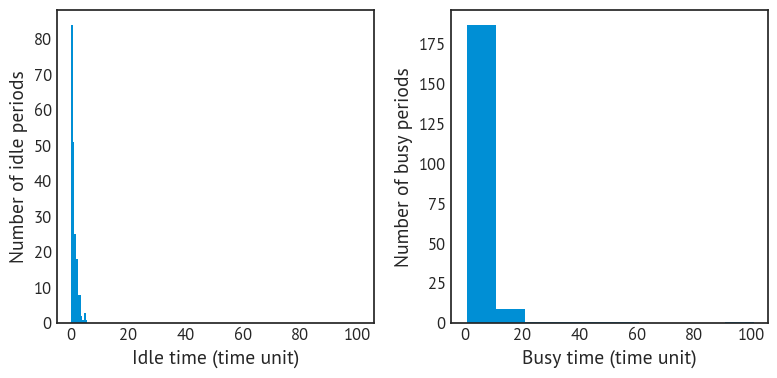

In [222]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(8,4))

ax[0].hist(idle_dt)
ax[0].set_ylabel('Number of idle periods')
ax[0].set_xlabel(r'Idle time (time unit)')

ax[1].hist(busy_dt)
ax[1].set_ylabel('Number of busy periods')
ax[1].set_xlabel(r'Busy time (time unit)')


plt.tight_layout()

#### 1.6 Little's law
Let's now test Little's law on the simulated process above, which say that at the _steady-state_ (if it exists), we have:
- $E[N_{S}] = \lambda \, E[T]$,

  where:
  - $\lim_{t \rightarrow \infty} \frac{1}{t}\,\int_{0}^{t}N_{S}(u)\, du = E[N_{S}]$

is the mean number of packets in the system; $\lambda$ is the mean rate of arrivals and $E[T]$ is the mean time spent in a state (system or queue). 



As we do not have the analytical expression for $N_S(t)$, we can approximate with discrete time intervals $\Delta t_n$, and
take the piece-wise constant integral with:
- $N_S(\Delta t_n) \approx \frac{1}{2} [N_S(t_{n+1}) + N_S(t_{n})]$

In [249]:
Exp_N_S = 0
for i in range(0,len(N_S)-1):
    Exp_N_S += 0.5 * (N_S[i+1]+N_S[i]) * (XaxisS[i+1] - XaxisS[i])


print(f"E[N_S] = {Exp_N_S /(XaxisS[-1]-XaxisS[0]):.3f} (piece-wise constant discrete approx)")

E[N_S] = 2.226 (piece-wise constant discrete approx)


Notice what you would get if you approximate:
- $N_S(t) \approx \hat{N}_S$,
- where $\hat{N}_S$ is the empirical mean $\hat{N}_S = \frac{1}{N} \sum_{n=1}^{N} N_S(t_n)$

In [252]:
print(f"E[N_S] = {np.mean(N_S[10:]):.3f} (empirical mean)")

E[N_S] = 2.704 (empirical mean)


Let's now compute the RHS of Little's law and compare:
 - $ \lim_{n\rightarrow \infty}\frac{1}{n} \sum_{k=1}^{n}T_{k} = E[T]$
 - $ \lim_{n\rightarrow \infty}\frac{1}{n}\sum_{k=1}^{n}(\tau_{k}-\tau_{k-1}) = \frac{1}{\lambda}$, where $\lambda$ is mean _rate_ of arrival

In [273]:
np.mean(taus), 1. / lambda_tau

(np.float64(1.0109670725423485), 1.0)

In [274]:
print(f"lambda x E[T] = {1. /np.mean(taus) * np.mean(T):.3f}")

lambda x E[T] = 2.229


In [275]:
print(f"lambda x E[T] = {lambda_tau * np.mean(T):.3f}")

lambda x E[T] = 2.253


#### Rerun with many more packets
TODO

## 2. D/D/1 example
- Both arrival and service time are _deterministic_  

We should vary and see what happens:
  1. $\rho <1$
  2. $\rho \sim 1$
  3. $\rho > 1$

In [115]:
seed = 10
prng = np.random.RandomState(seed)

In [135]:
x_c = 0.5
tau_c = 1.0 
rho = x_c / tau_c
print(f"rho = {rho:.2f}")
assert x_c / tau_c < 1

rho = 0.50


In [129]:
n = 20 # number of packets
taus = tau_c * np.ones(n)
xs = x_c * np.ones(n)

In [130]:
ts = np.cumsum(taus)

In [131]:
w,T,v = simulate_queueing_system(taus,xs)

In [132]:
s = 100
new_v, Xaxis = get_intermediate_v(v,T,ts,s=s)
N_S, XaxisS = get_N_S(T,ts,s)

assert len(N_S) == len(XaxisS)

In [133]:
outfile = None

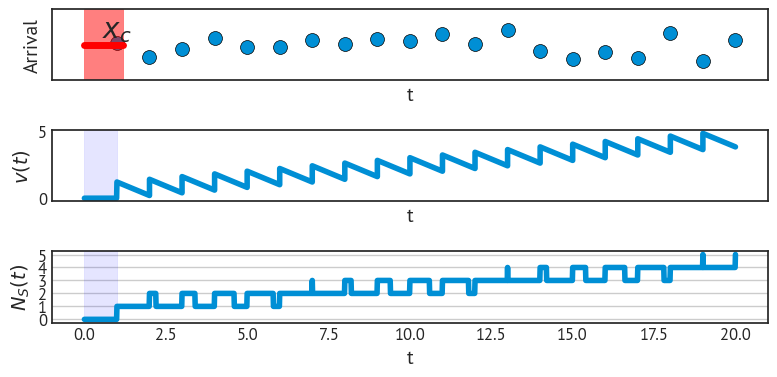

In [134]:

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,4))

ax[0].scatter(ts, np.ones(n) * prng.uniform(-1,1, size=n) * 0.5, s = 100, edgecolors='black')
ax[0].set_ylabel('Arrival')
ax[0].set_xlabel('t')
ax[0].set(yticklabels=[])
ax[0].set_ylim(-1,1)
# plt.yticks(np.arange(1,2))

ax[1].plot(Xaxis,new_v)
ax[1].set_ylabel(r'$v(t)$')
ax[1].set_xlabel('t')

ax[2].plot(XaxisS,N_S)
ax[2].set_ylabel(r'$N_S(t)$')
ax[2].set_xlabel('t')
ax[2].set_yticks(np.arange(max(N_S)+1))
ax[2].grid(axis='y')

'''
Highlight idle times
'''
idle_times = zero_runs(new_v)
for i,(a,b) in enumerate(idle_times):
    ax[1].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')
    ax[2].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')

'''
Highlight mean service time
'''
ax[0].fill_betweenx(np.ones(n),np.zeros(n),np.mean(xs) * np.ones(n))
ax[0].axvspan(0, np.mean(xs), alpha=0.5, color='red')
ax[0].plot([0,np.mean(xs)],[0,0],lw=5,color='r')
ax[0].text(np.mean(xs) * 0.5 * 0.9,0.2,r'$x_c$', fontsize=20)
plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

Check the waiting times

In [124]:
outfile = None

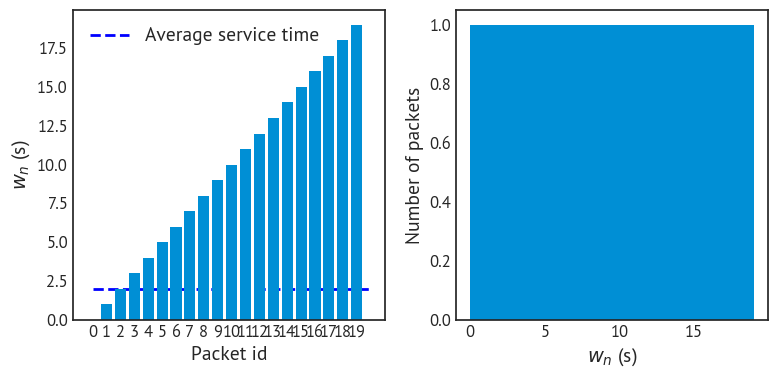

In [125]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[0].bar(np.arange(n), w)
ax[0].set_xlabel('Packet id')
ax[0].set_ylabel(r'$w_n$ (s)')
ax[0].set_xticks(np.arange(n),labels=np.arange(n))
x_axis = np.linspace(0,n,100)
avg_xs = np.mean(xs)
ax[0].plot(x_axis,np.ones(x_axis.shape[0])*avg_xs,ls='--',label= 'Average service time', c='b', lw=2, zorder=0)
ax[0].legend()
           
ax[1].hist(w,bins=20)
ax[1].set_ylabel('Number of packets')
ax[1].set_xlabel(r'$w_n$ (s)')


plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

Check busy and idle times

In [126]:
idle_times = zero_runs(new_v)
busy_times = zero_runs(new_v,is_zero=False)

idle_dt = []
busy_dt = []

for i,(a,b) in enumerate(idle_times):
    idle_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])
for i,(a,b) in enumerate(busy_times):
    busy_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])
    

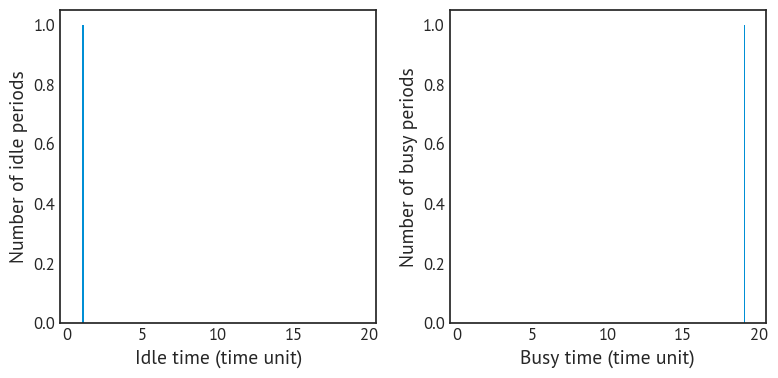

In [127]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(8,4))

ax[0].hist(idle_dt)
ax[0].set_ylabel('Number of idle periods')
ax[0].set_xlabel(r'Idle time (time unit)')

ax[1].hist(busy_dt)
ax[1].set_ylabel('Number of busy periods')
ax[1].set_xlabel(r'Busy time (time unit)')


plt.tight_layout()

#### 2.1 Little's law

In [107]:
Exp_N_S = 0
for i in range(len(N_S)-1):
    Exp_N_S += 0.5 * (N_S[i+1]+N_S[i]) * (XaxisS[i+1] - XaxisS[i])


print(f"E[N_S] = {Exp_N_S /(XaxisS[-1]-XaxisS[0]):.3f}")

E[N_S] = 1.565


In [108]:
print(f"E[N_S] = {np.mean(N_S):.3f}")

E[N_S] = 1.571


In [109]:
print(f"lambda x E[T] = {np.mean(taus) * np.mean(T):.3f}")

lambda x E[T] = 2.100


In [110]:
print(f"lambda x E[T] = {lambda_tau * np.mean(T):.3f}")

lambda x E[T] = 2.100


## 3. M/M/1 example

We know that this system can be modeled as a continous-time Markov process with:  
$
Q = \left[ \begin{array}{cccccc}
		-\lambda & \lambda&0&0& 0&\dots\\
		\mu & -(\lambda + \mu)& \lambda &0& 0&\dots\\
		0 & 	\mu & -(\lambda + \mu)& \lambda & 0 & \dots\\
		\dots &\dots &\dots &\dots &\dots &\dots 
		\end{array}
	\right] \quad.
$

and that we can derive analytical expressions for the steady-state:  
$
\pi_{i} = (1-\rho)\, \rho^{i} \quad.
$

We can now see this empirically by simulating from this process. 


#### 3.1 Simulate the system

We can start by sampling arrival and service times

In [312]:
seed = 10
prng = np.random.RandomState(seed)


Vary $n$ and $\rho$ and see what happens:
- Small $n$ and $\rho<1$
- Larger $n$ and $\rho<1$
- Large $n$ and $\rho \approx 1$

In [483]:
n = 10 # number of packets
lambda_tau = 1. # E[tau] = 1/lambda_tau
taus = prng.exponential(scale=1/lambda_tau, size=n)
ts = np.cumsum(taus)

mu_x = 2. # E[x] = 1/mu_x
xs = prng.exponential(scale=1/mu_x, size=n)

First let's check that we are in the favorable regime:

$\rho = \frac{\lambda}{\mu} <1$

In [476]:
rho = lambda_tau / mu_x
print(f"rho = {rho:.2f}")
assert rho < 1

rho = 1.00


Let's generate data

In [477]:
w,T,v = simulate_queueing_system(taus,xs)

new_v, Xaxis = get_intermediate_v(v,T,ts,s=1000)
N_S, XaxisS = get_N_S(T,ts,s)

assert len(N_S) == len(XaxisS)

And visualize the process

In [478]:
outfile = None

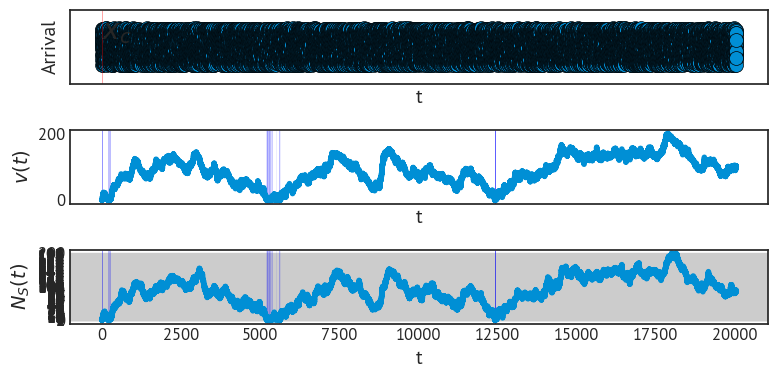

In [479]:

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,4))

ax[0].scatter(ts, np.ones(n) * prng.uniform(-1,1, size=n) * 0.5, s = 100, edgecolors='black')
ax[0].set_ylabel('Arrival')
ax[0].set_xlabel('t')
ax[0].set(yticklabels=[])
ax[0].set_ylim(-1,1)
# plt.yticks(np.arange(1,2))

ax[1].plot(Xaxis,new_v)
ax[1].set_ylabel(r'$v(t)$')
ax[1].set_xlabel('t')

ax[2].plot(XaxisS,N_S)
ax[2].set_ylabel(r'$N_S(t)$')
ax[2].set_xlabel('t')
ax[2].set_yticks(np.arange(max(N_S)+1))
ax[2].grid(axis='y')

'''
Highlight idle times
'''
idle_times = zero_runs(new_v)
for i,(a,b) in enumerate(idle_times):
    ax[1].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')
    ax[2].axvspan(Xaxis[a], Xaxis[min(b,len(Xaxis)-1)], alpha=0.1, color='b')

'''
Highlight mean service time
'''
ax[0].fill_betweenx(np.ones(n),np.zeros(n),np.mean(xs) * np.ones(n))
ax[0].axvspan(0, np.mean(xs), alpha=0.5, color='red')
ax[0].plot([0,np.mean(xs)],[0,0],lw=5,color='r')
ax[0].text(np.mean(xs) * 0.5 * 0.9,0.2,r'$x_c$', fontsize=20)
plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

We can notice several blue-shaded areas, the idle times.

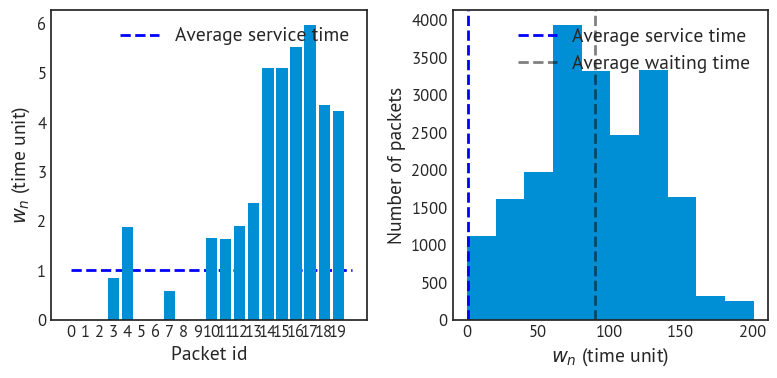

In [480]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

nmax = min(n,20)
ax[0].bar(np.arange(n)[:nmax], w[:nmax])
ax[0].set_xlabel('Packet id')
ax[0].set_ylabel(r'$w_n$ (time unit)')
ax[0].set_xticks(np.arange(n)[:nmax],labels=np.arange(n)[:nmax])
x_axis = np.linspace(0,nmax,100)
avg_xs = np.mean(xs)
ax[0].plot(x_axis,np.ones(x_axis.shape[0])*avg_xs,ls='--',label= 'Average service time', c='b', lw=2, zorder=0)
ax[0].legend()
           
ax[1].hist(w)
ax[1].set_ylabel('Number of packets')
ax[1].set_xlabel(r'$w_n$ (time unit)')
# ax[1].plot(x_axis,np.ones(x_axis.shape[0])*avg_xs)
ax[1].axvline(x=avg_xs,ls='--',label= 'Average service time', c='b', lw=2, zorder=1)
ax[1].axvline(x=np.mean(w),ls='--',label= 'Average waiting time', c='black', lw=2, zorder=1, alpha=0.5)
ax[1].legend()

plt.tight_layout()
# plt.show()
if outfile is not None:
    
    plt.savefig(f"{outdir}{outfile}", dpi=dpi, format=None, metadata=None,
                bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None
                )
    print(f"Figure saved in {outdir}{outfile}")
        
plt.show()

#### 3.2 Long-run expected number of packets in the system
We can now compare $N_S(t)$ in the long-run with the expected value of the distribution $\pi_i$: 

$
 E[N_{S}(t)] = E[{\text{geom}(\rho)}] = \frac{\rho}{1-\rho} =\frac{\lambda}{\mu-\lambda} \quad.
$

In [481]:
Exp_N_S = 0
for i in range(0,len(N_S)-1):
    Exp_N_S += 0.5 * (N_S[i+1]+N_S[i]) * (XaxisS[i+1] - XaxisS[i])


print(f"Data E[N_S] = {Exp_N_S /(XaxisS[-1]-XaxisS[0]):.3f} (piece-wise constant discrete approx)")

Data E[N_S] = 90.514 (piece-wise constant discrete approx)


In [482]:
print(f"Data = {np.mean(N_S):.2f} (empirical average approx)")

Data = 90.49 (empirical average approx)


In [460]:
exp_N_s_theo = lambda_tau / (mu_x-lambda_tau)
print(f"Theory = {exp_N_s_theo:.2f}")

Theory = 1000.00


#### 3.3 Long-run idle and busy periods

We can compare with the expected value of $\pi_0$ and $1-\pi_0$

In [467]:
pi0 = 1 - lambda_tau / mu_x

In [468]:
idle_times = zero_runs(new_v)
busy_times = zero_runs(new_v,is_zero=False)

In [469]:
idle_dt = []
busy_dt = []

for i,(a,b) in enumerate(idle_times):
    idle_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])
for i,(a,b) in enumerate(busy_times):
    busy_dt.append(Xaxis[min(b,len(Xaxis)-1)]-Xaxis[a])

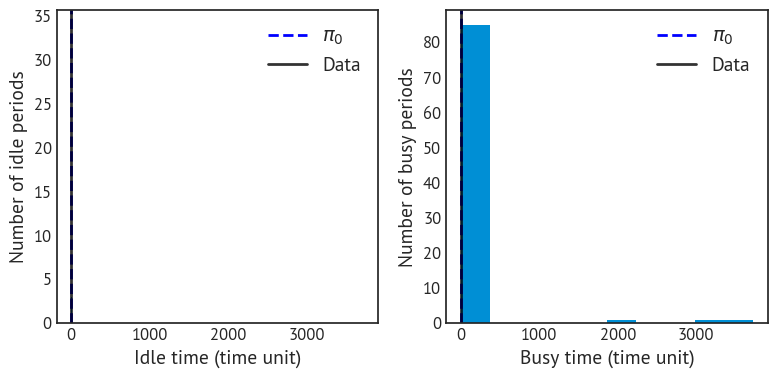

In [470]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(8,4))

ax[0].hist(idle_dt)
ax[0].set_ylabel('Number of idle periods')
ax[0].set_xlabel(r'Idle time (time unit)')
ax[0].axvline(x=pi0,ls='--',label= r'$\pi_0$', c='b', lw=2, zorder=1)
ax[0].axvline(x=np.mean(idle_dt)/(np.mean(idle_dt)+np.mean(busy_dt)),ls='-',label= f"Data", c='black', lw=2, zorder=1,alpha=0.8)
ax[0].legend()

ax[1].hist(busy_dt)
ax[1].set_ylabel('Number of busy periods')
ax[1].set_xlabel(r'Busy time (time unit)')
ax[1].axvline(x=1-pi0,ls='--',label= r'$\pi_0$', c='b', lw=2, zorder=1)
ax[1].axvline(x=np.mean(busy_dt)/(np.mean(idle_dt)+np.mean(busy_dt)),ls='-',label= f"Data", c='black', lw=2, zorder=1,alpha=0.8)
ax[1].legend()


plt.tight_layout()

**Idle** proportion of time

In [473]:
print(f"Theory: {pi0:.3f}")
print(f"Data: {np.sum(idle_dt)/(np.sum(idle_dt)+np.sum(busy_dt)):.3f}")

Theory: 0.001
Data: 0.007


**Busy** proportion of time

In [474]:
print(f"Theory: {1-pi0:.3f}")
print(f"Data: {np.sum(busy_dt)/(np.sum(idle_dt)+np.sum(busy_dt)):.3f}")

Theory: 0.999
Data: 0.993
